Initial allele frequency (x0): 0.0005
Estimated eventual fixation probability: nan


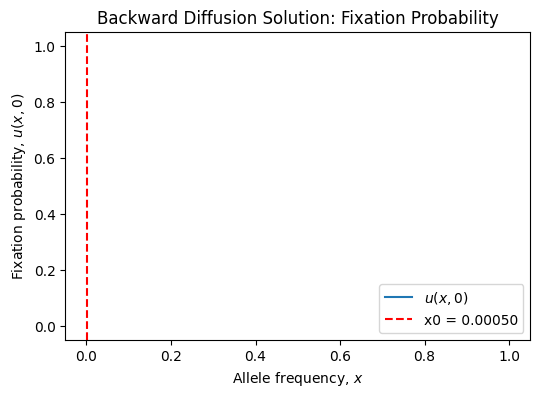

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import interp1d

def solve_backward_diffusion(s_driver, c, Ne, T_final, M, N_time):
    """
    Solves the backward Kolmogorov equation for fixation probability:
    
      - u_t = [s_driver - c*t] * x(1-x) u_x + (1/2) * (x(1-x)/Ne) u_xx
    
    with boundary conditions u(0,t)=0 and u(1,t)=1.
    
    The spatial domain [0,1] is divided into M intervals (M+1 grid points)
    and the time interval [0, T_final] is divided into N_time steps.
    Integration is done backward in time from t = T_final to t = 0.
    
    We use a smooth terminal condition u(x, T_final) = x (the neutral fixation probability),
    which is more numerically stable.
    
    Returns:
      x: the spatial grid (allele frequencies)
      u(x,0): the eventual fixation probability as a function of initial frequency.
    """
    # Spatial discretization
    dx = 1.0 / M
    x = np.linspace(0, 1, M+1)
    
    # Time discretization: t_j = T_final - j*dt, j=0,...,N_time.
    dt = T_final / N_time
    t_grid = T_final - np.arange(N_time+1) * dt  # t=T_final at j=0, t=0 at j=N_time
    
    # Terminal condition: use u(x, T_final) = x (smooth condition)
    u = np.zeros((M+1, N_time+1))
    u[:, 0] = x   # ensures u(0)=0 and u(1)=1 exactly
    
    # Time marching: integrate backward from t = T_final (j=0) to t = 0 (j=N_time)
    for j in range(0, N_time):
        t_next = t_grid[j+1]  # new time level
        
        # Bound the time-dependent selection coefficient
        s_t = max(-1, min(s_driver - c * t_next, 1))
        
        n_int = M - 1  # interior grid points (i = 1,..., M-1)
        a = np.zeros(n_int)       # subdiagonal coefficients
        b = np.zeros(n_int)       # main diagonal coefficients
        c_coeff = np.zeros(n_int) # superdiagonal coefficients
        d = np.zeros(n_int)       # right-hand side
        
        for i in range(1, M):
            xi = x[i]
            # Drift coefficient at time t_next
            A = s_t * xi * (1 - xi)
            # Diffusion coefficient
            B = 0.5 * (xi * (1 - xi)) / Ne
            
            a[i-1] = - dt * (A / (2 * dx)) + dt * (B / (dx**2))
            b[i-1] = 1 - 2 * dt * (B / (dx**2))
            c_coeff[i-1] = dt * (A / (2 * dx)) + dt * (B / (dx**2))
            d[i-1] = u[i, j]
        
        # Adjust for boundary at x=1: u(M)=1
        d[-1] -= c_coeff[-1] * 1.0
        
        # Build the tridiagonal matrix using SciPy's sparse routines.
        diagonals = [a[1:], b, c_coeff[:-1]]
        offsets = [-1, 0, 1]
        A_matrix = diags(diagonals, offsets, shape=(n_int, n_int)).tocsc()
        # Solve the tridiagonal system.
        u_inner = spsolve(A_matrix, d)
        
        # Update the solution at interior points.
        u[1:M, j+1] = u_inner
        
        # Enforce boundary conditions.
        u[0, j+1] = 0.0
        u[M, j+1] = 1.0
        
    # u(:, N_time) is u(x,0), the eventual fixation probability as a function of x.
    return x, u[:, -1]

# -----------------------------------------------------------------------------
# Model and numerical parameters based on literature insights:
s_driver = 0.2          # beneficial effect (initial advantage)
c = 0.026               # chosen so that s(t) = s_driver - c*t becomes strongly negative by T_final
Ne = 1000               # effective population size
T_final = 200.0         # terminal time; here s(T_final) ~ 0.2 - 0.026*200 = -5.0
M = 200                 # use 200 spatial intervals (201 grid points) for higher resolution
N_time = 40000          # use 40,000 time steps for improved stability (dt = T_final/N_time)

# Solve the backward diffusion equation to obtain u(x,0)
x_grid, u0 = solve_backward_diffusion(s_driver, c, Ne, T_final, M, N_time)

# For a new autosomal mutation in a diploid population, the initial frequency is ~1/(2Ne)
x0 = 1 / (2 * Ne)

# Interpolate u(x,0) to obtain the fixation probability at x0.
fix_prob_interp = interp1d(x_grid, u0, kind='linear', fill_value="extrapolate")
fixation_probability = fix_prob_interp(x0)

print("Initial allele frequency (x0):", x0)
print("Estimated eventual fixation probability:", fixation_probability)

# Plot the fixation probability curve u(x,0)
plt.figure(figsize=(6,4))
plt.plot(x_grid, u0, label='$u(x,0)$')
plt.axvline(x=x0, color='red', linestyle='--', label=f'x0 = {x0:.5f}')
plt.xlabel('Allele frequency, $x$')
plt.ylabel('Fixation probability, $u(x,0)$')
plt.title('Backward Diffusion Solution: Fixation Probability')
plt.legend()
plt.show()
